# How to Easily Perform Outlier Detection In Python For Machine Learning, #2
## Earth is an outlier - the code, part 2
![](images/pixabay.jpg)
<figcaption style="text-align: center;">
    Image by <a href="https://pixabay.com/users/alexas_fotos-686414/?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=1744091">Alexa</a> from <a href="https://pixabay.com//?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=1744091">Pixabay</a>
</figcaption>

### Introduction

The first question to ask before starting outlier detection is "Does my dataset even have outliers?". While the usual answer is "Yes", it is always recommended to sniff the hint of outlier presence in the air before making big efforts (like using machine learning models) to isolate them.

So, we will start off this second part of our outlier detection tutorial series by looking at general methods of detecting the presence of outliers like data visualization. Then, we will continue the post by talking about methods to detect both univariate and multivaraite outliers.
 
Let's get started!

### The dataset to be used

We'll be using the Diamonds dataset throughout the tutorial. It is large enough for it to not be a toy dataset and it has got a nice combination of numeric and categorical features. 

```
import seaborn as sns

diamonds = sns.load_dataset("diamonds")
diamonds.head()
```

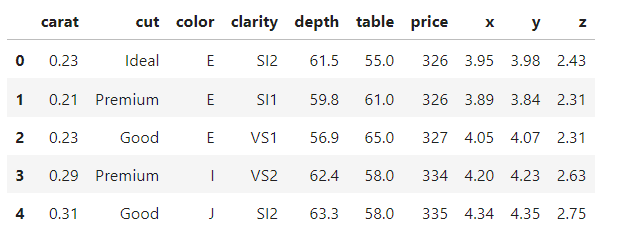

Our eventual task after outlier detection is predicting the carat of diamonds given its physical characteristics and price:

In [3]:
diamonds.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

Before we get to that part, we want to detect and isolate the outliers to make our dataset as clean as possible (it is relatively clean now).

So, let's extract the feature and target arrays and encode the categorical columns using OrdinalEncoder class from Sklearn:

In [5]:
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

# Extract feature and target arrays
X, y = diamonds.drop("carat", axis=1), diamonds["carat"]
# Select categorical column names
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Encode categoricals
X.loc[:, cats] = OrdinalEncoder().fit_transform(X[cats])

Now, we are ready...

### Do outliers even exist?

...to answer the question "Do outliers even exist"? The first step is to look at the summary statistics of the target variable - carat. We are looking if there are suspicious enough gaps between the minimum, mean and maximum of the target.

In [6]:
y.describe()

count    53940.000000
mean         0.797940
std          0.474011
min          0.200000
25%          0.400000
50%          0.700000
75%          1.040000
max          5.010000
Name: carat, dtype: float64

The values are 0.2, 0.8 and 5.01 for minimum, mean and maximum respectively. The large gaps between the minimum and maximum and between mean and the maximum already suggest there might be outliers (remember, outliers are often the extreme datapoints in distributions).

Let's confirm this suspicion by plotting the histogram of the target:

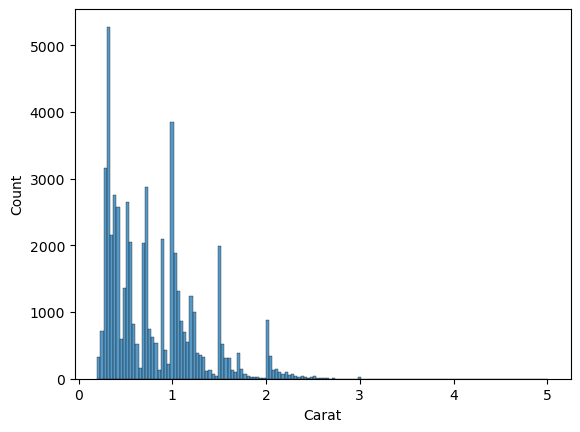

In [8]:
import matplotlib.pyplot as plt
sns.histplot(y)

plt.xlabel("Carat");

As we can see, the bulk of the histogram is between 0.2 and 3 carats. But the right tail of histogram goes up to 5, but we can't see any bins there. If you see a histogram with long left or right tail but no bins in the tails, this means there is a small quantity of extreme values (outliers) in the distribution.

Now, let's look at the features array:

```
X.drop(cats, axis=1).describe()
```

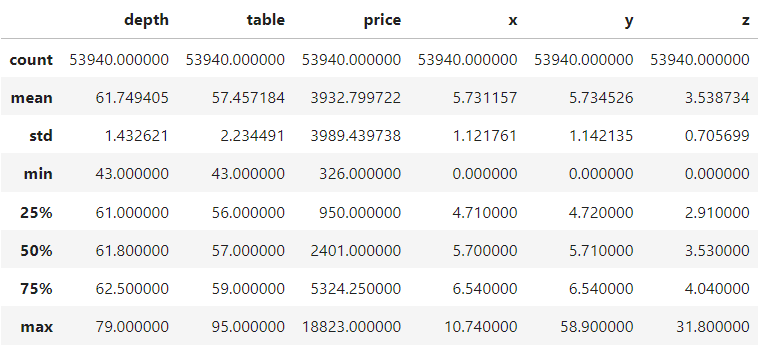

After excluding the categorical features, we can probably guess that price is the most important feature. And like carat, we can see big differences between the mean price and the cheapest and most expensive diamonds. Let's plot a histogram again:

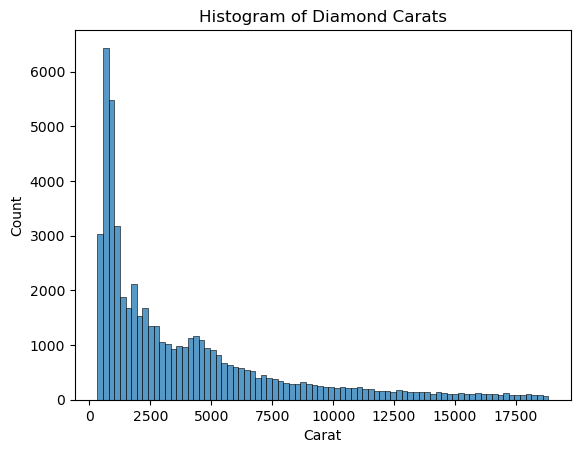

In [10]:
sns.histplot(X["price"])

plt.title("Histogram of Diamond Carats")
plt.xlabel("Carat");

We can see that the majority of datapoints lie below 5000$; the rest of the bins have very low height. This is getting tricky - do we consider all the points above 5000 as outliers, now? That would be a large proportion of the dataset. 

Let's look more closely by plotting a boxplot of diamond cut quality versus price. The cut quality is given in descending order from left to right. 

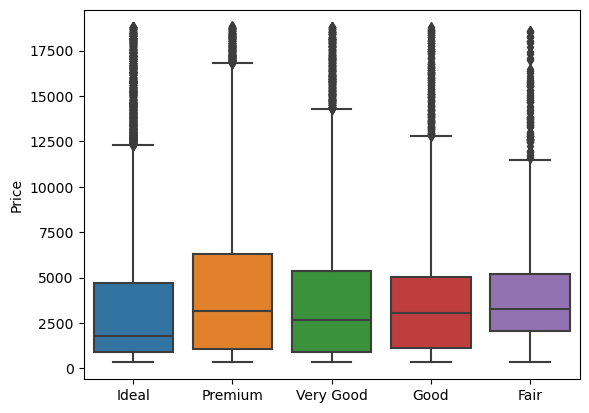

In [11]:
sns.boxplot(x="cut", y="price", data=diamonds, whis=2)

plt.xlabel("")
plt.ylabel("Price");

Even though we see many outliers in the plot marked with circles above the whiskers of the boxes, we can't safely conclude they are outliers.

If you pay attention, the highest quality, ideal diamonds have prices around 2000\$ (look at the median) and yet, the lowest quality, fair diamonds cost much more, around 3000\\$ . This suggests that there exists some hidden multivariate relationships between the features of the dataset, and that we can't draw conclusions from just single and two-variable plots.

Actually, this is the case for almost all datasets. Plain descriptive statistics and simple plots can only hint the presence of outliers. And since we can't really see the big picture relationships among all features using these methods, we have to turn to more sophisticated techniques.

### Univariate outlier detection

First, let's look at techniques that allow us to detect outliers in single distributions, like our target array of diamond carats.

One of the most popular methods to perform outlier detection on such univariate datasets is using plain-old z-scores. Recall that a z-score of a datapoint tells us how many standard deviations it is away from the mean. 

For example, if distribution A have a mean of 5 and standard deviation of 3.2, the sample 17.2 would have a z-score of (17.2 - 5) / 3.2 = 3.8125.

We can calculate the z-score of all elements in an array using the `zscore` function from `scipy`:

In [13]:
from scipy.stats import zscore

zscore(y).abs()[:5]

0    1.198168
1    1.240361
2    1.198168
3    1.071587
4    1.029394
Name: carat, dtype: float64

In statistics, a z-score of 3 is commonly used as a threshold between inliers and outliers. So, using array filtering we can mark any samples as outliers if the absolute value of their z-score is higher than 3:

In [14]:
from scipy.stats import zscore

is_outlier = zscore(y).abs() > 3
outliers_y = y[is_outlier]

num_outliers = len(outliers_y)
print(f"The number of outliers: {num_outliers}")
print(f"Percentage of outliers: {num_outliers / len(y):.3f}")

The number of outliers: 439
Percentage of outliers: 0.008


The method marks 0.8% of samples as outliers and that's not a coincidence. The idea of using a z-score of three as a threshold for outliers comes from the Empirical Rule.

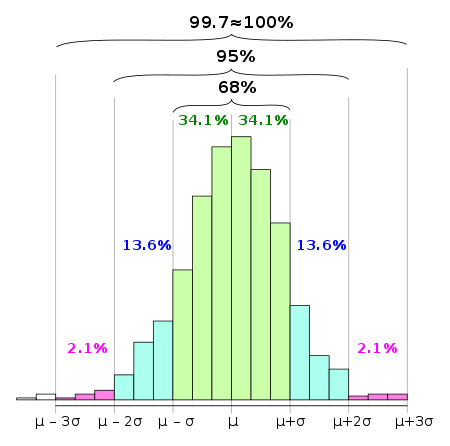

CC BY-SA

The [Empirical Rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule) states that data within one, two, three standard deviations or z-scores roughly represent 68%, 95% and 99.7% of the  distribution, respectively.

So, if a sample have a z-score higher than 3, we can safely conclude that is an extreme value since it doesn't belong to roughly 99.7% of the dataset.

We found 439 outliers using the z-scores method but can we really trust this output? Actually, we can't. 

The Empirical Rule, and in turn, z-scores are only appropriate to normally distributed data. And from the histogram of diamond carats we saw earlier, we know for a fact that our target, y, is not normally distributed:

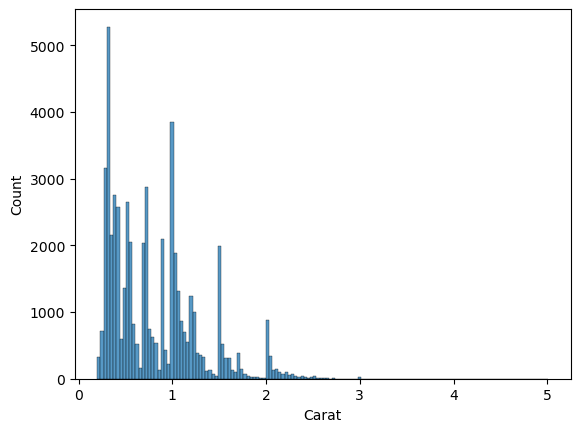

So, we must take another approach now.

### Modified z-scores

When your distribution isn't normal, z-scores won't cut it to detect outliers. Instead, you can use the brother of z-scores - Median Absolute Deviation (MAD), also called modified z-scores.

The idea is simple - since outliers most affect the mean and standard deviation of distributions, we will stop using those metrics and replace them with the median.

> Why replace mean with the median? Median denotes the 50th percentile, which represents the middle value of a distribution when it is sorted. This means no matter how big or small outliers are, they won't affect the median's value in the slightest.

When we replace the mean with the median in the standard deviation formula, we get median absolute deviation. It is calculated by subtracting the median from each sample in the distribution, taking the absolute value and then, the median of differences. Here is how to do that operation in NumPy for our target, y:

In [16]:
median_y = y.median()

abs_diffs = (y - median_y).abs()
mad = abs_diffs.median()

mad

0.32000000000000006

We can confirm our calculations are correct using the `median_abs_deviation` function from `scipy`:

In [85]:
from scipy.stats import median_abs_deviation

median_abs_deviation(y)

0.32000000000000006

We get the same result. Now, if we insert the MAD value into the following formula, we get modified z-scores:

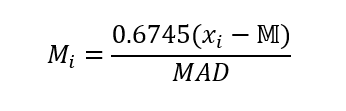

where M is the median and x_i is the ith sample of the distribution.

In modified z-scores, a MAD score of 3.5 is used as a threshold for outliers. The formula is already implemented as `MAD` estimator in PyOD library. Let's see how to use it:

In [18]:
from pyod.models.mad import MAD

mad = MAD().fit(y.values.reshape(-1, 1))

labels = mad.labels_
labels

array([0, 0, 0, ..., 0, 0, 0])

Once you import the estimator from `models.mad`, you can fit to the target array `y`. By default, all PyOD estimators require 2D arrays, so we are feeding y after we've reshaped it.

After MAD is fit, we can access inlier/outlier labels for each sample using the `labels_` attribute. It returns 0 for inliers and 1 for outliers. 

Let's count the ones:

In [19]:
outliers_y_mad = y[labels == 1]

num_outliers = len(outliers_y_mad)
print(f"The number of outliers: {num_outliers}")
print(f"Percentage of outliers: {num_outliers / len(y):.3f}")

The number of outliers: 222
Percentage of outliers: 0.004


As you can see, `MAD` estimator found 222 outliers, as compared to the 439 we found with z-scores. Since `MAD` uses robust metrics like median, we can trust this output more. 

Let's plot the histogram of diamond carats once more after we remove the outliers:

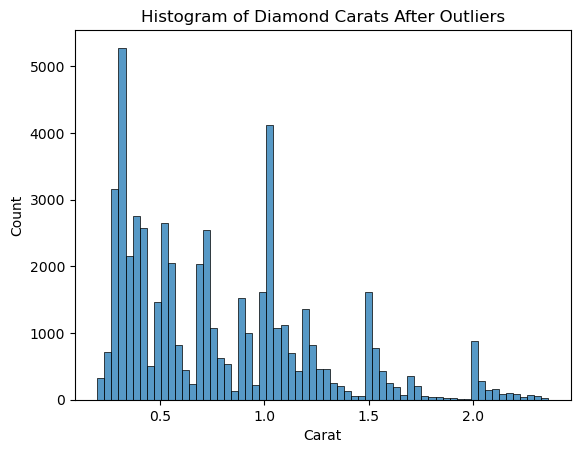

In [20]:
inliers = y[labels == 0]

sns.histplot(inliers)

plt.title("Histogram of Diamond Carats After Outliers")
plt.xlabel("Carat");

As we can see, the tail of the histogram is gone.

### Conclusion

Here is a summary of the steps you can take to perform outlier detection when given a new dataset:

1. Check if there are even outliers to begin with using basic methods like summary statistics, histograms and boxplots.
2. Once you have a reasonable assumption for the presence of outliers, you can start univariate outlier detection on the target array.
3. If the array is normally distributed, you can go with z-scores.
4. If you don't know distribution type or confirmed that it isn't normal, you can use modified z-scores with a threshold of 3.5.

Thank you for reading!

https://ibexorigin.medium.com/membership

https://ibexorigin.medium.com/subscribe